<a href="https://colab.research.google.com/github/rradams/MUSA650_RemoteSensing_Final/blob/main/Urban_Expansion_Final_Code_aug_RA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MUSA 650: Remote Sensing - Final Project**

Identifying Urban Expansion in Cirebon, Indonesia

Rebekah Adams and Tiffany Tran

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import math
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop # optimizer
import keras
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


# Set up functions

In [2]:
import pandas as pd

# Create dataframe of prediction accuracies

def prediction_by_category(model, test_set):
  categories_dict = {1:"Urban", 0:"Not_Urban"}
  predict_x=model.predict(test_set) # predictions with probabilities for each class

  # find accurate predictions
  label_count = np.unique(Y_test, return_counts = True)[1] # number of labels of test set
  classes_x=np.argmax(predict_x,axis=1) # the class with the highest-predicted probabilities, i.e. the best guess
  y_test_pred = [categories_dict[x] for x in classes_x] # convert the predictions to the category names
  y_test_true = [categories_dict[x] for x in Y_test] # convert the true labels to the category names

  # Create dataframe
  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)

  return(pred_df)

In [3]:
# Create function to plot confusion matrix
def plot_cm(model, test_data, title):
  predict_x = model.predict(test_data)
  classes_x = np.argmax(predict_x, axis=1)
  cm = confusion_matrix(Y_test, classes_x)
  disp = ConfusionMatrixDisplay(confusion_matrix= cm,
                                display_labels=categories)
  
  return(
      disp.plot(),
      disp.ax_.set_title(f"{title}")
  )

In [69]:
# Create function to plot ROC curve - how to make less angular?
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_set):
  #predict_x=model.predict(test_set) # predictions with probabilities for each class
  #classes_x=np.argmax(predict_x,axis=1) # the class with the highest-predicted probabilities, i.e. the best guess
  probabilities = model.predict(test_set) # predictions with probabilities for each class
  probabilities_max = np.argmax(probabilities, axis=1) # the class with the highest-predicted probabilities, i.e. the best guess

  # Compute fpr, tpr, thresholds and roc auc
  fpr, tpr, thresholds = roc_curve(Y_test, probabilities_max)
  #fpr, tpr, thresholds = roc_curve(Y_test, classes_x)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  return(
      plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc),
      plt.plot([0, 1], [0, 1], 'k--'),  # random predictions curve
      plt.xlim([0.0, 1.0]),
      plt.ylim([0.0, 1.0]),
      plt.xlabel('False Positive Rate or (1 - Specifity)'),
      plt.ylabel('True Positive Rate or (Sensitivity)'),
      plt.title('Receiver Operating Characteristic'),
      plt.legend(loc="lower right")
  )


# # ROC curve - why so angular?
# from sklearn.metrics import roc_curve, auc

# predict_x=handmade_cnn.predict(X_test) # predictions with probabilities for each class
# classes_x=np.argmax(predict_x,axis=1) # the class with the highest-predicted probabilities, i.e. the best guess
# probabilities = handmade_cnn.predict(X_test)
# probabilities_2 = np.argmax(probabilities, axis=1)

# # Compute fpr, tpr, thresholds and roc auc
# fpr, tpr, thresholds = roc_curve(Y_test, probabilities_2)
# #fpr, tpr, thresholds = roc_curve(Y_test, classes_x)
# roc_auc = auc(fpr, tpr)

# # # Plot ROC curve
# plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
# plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate or (1 - Specifity)')
# plt.ylabel('True Positive Rate or (Sensitivity)')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")

In [5]:
  # Plot images of False Positives - images that were predicted as Urban, but were actually Not Urban
  # This could help us identify areas of urban expansion

from mpl_toolkits.axes_grid1 import ImageGrid

def plot_false_positives(model, test_set):

    predict_x = model.predict(test_set)
    classes_x = np.argmax(predict_x,axis=1)
    wrong_classifications = classes_x - Y_test # predicted classes - actual classes
    wrong_classifications_index = np.where(wrong_classifications != 0) # index of where predictions were wrong
    wrong_predictions = classes_x[wrong_classifications_index] # use index to find wrong predictions
    wrong_y_true = Y_test[wrong_classifications_index] # use index to find correct labels of wrong predictions
    wrong_x_true = X_test[wrong_classifications_index] # use index to find pixels of incorrectly-predicted images

    # Identify False Positive - true Not Urban, predicted as Urban
    FP_index = np.where(wrong_y_true == 0) # find labels Not Urban areas, i.e. the false positives (Non-Urban labelled as 0)
    FP_labels = wrong_y_true[FP_index]
    FP_images = wrong_x_true[FP_index]

    # Select random sample of images from false positive results
    index_list = []

    for i in range(0,4):
      random_index = np.random.choice(FP_labels.shape[0])
      index_list.append(random_index)

    # Use random index to select four random images
    image_1 = FP_images[index_list[0]].reshape(64,64,3)
    image_2 = FP_images[index_list[1]].reshape(64,64,3)
    image_3 = FP_images[index_list[2]].reshape(64,64,3)
    image_4 = FP_images[index_list[3]].reshape(64,64,3)

    # Plot
    fig = plt.figure() #figsize=(4., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, [image_1, image_2, image_3, image_4]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    return(grid.axes_all[1].set_title("Examples of False Positive Classifications - Predicted as Urban, but are officially not urban"))

In [6]:
# Function to plot accuracy and loss for each model
def plot_accuracy_and_loss(model_history):
  return(
    plt.plot(model_history.history['accuracy']),
    plt.plot(model_history.history['val_accuracy']),
    plt.title('model accuracy'),
    plt.ylabel('accuracy'),
    plt.xlabel('epoch'),
    plt.legend(['train', 'test'], loc='upper left'),
    plt.show(),

    plt.plot(model_history.history['loss']),
    plt.plot(model_history.history['val_loss']),
    plt.title('model loss'),
    plt.ylabel('loss'),
    plt.xlabel('epoch'),
    plt.legend(['train', 'test'], loc='upper left'),
    plt.show(),
  )

# Import images

In [12]:
# import images

import os
import skimage
from skimage import io
import numpy as np
from glob import glob
from pathlib import Path
#pip install imagecodecs
#import imagecodecs

raw_labels =[]
raw_images = []
raw_label_names = []
here = Path(os.getcwd())

for idx, directory in enumerate((here / "drive/MyDrive/MUSA650_RemoteSensing_Final/data/").glob("*")):  # keep this line for running on colab
#for idx, directory in enumerate((here / "./data/cirebon").glob("*")):  # Keep this line for running locally
    for img_path in directory.glob("*.jpg"):
        raw_labels.append(idx)
        raw_label_names.append(directory)
        raw_images.append(io.imread(img_path))
        
# convert to numpy arrays
images = np.array(raw_images)
images = images[:, :64, :64, :3] # trim extra pixel and alpha channel
labels = np.array(raw_labels)
label_names = np.array(raw_label_names)

In [13]:
label_names

array([PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban'),
       ...,
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban')],
      dtype=object)

In [14]:
# examine - what are urban and non-urban classified as?
labels

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
# If need to flip 1s and 0s for urban/not urban:

# Switch 0s to 1s and 1s to 0s (so urban = 1, not_urban = 0)
# flip 1s to 0s and 0s to 1s
labels_flip = np.logical_not(labels).astype(int)

# print old vs. new array
print(labels)
print(labels_flip)

[0 0 0 ... 1 1 1]
[1 1 1 ... 0 0 0]


In [16]:
# check shape
images.shape

(1424, 64, 64, 3)

In [17]:
# Confrim the range of values in the dataset - yes, they are between 0 and 255 # Do we need to scale this?
print("Max pixel value is: ", images.max())
print("Min pixel value is: ", images.min())

Max pixel value is:  255
Min pixel value is:  0


In [18]:
urban_labels_index = np.where(labels_flip == 1)
urban_labels = labels_flip[urban_labels_index]
urban_images = images[urban_labels_index]

In [19]:
urban_images.shape

(114, 64, 64, 3)

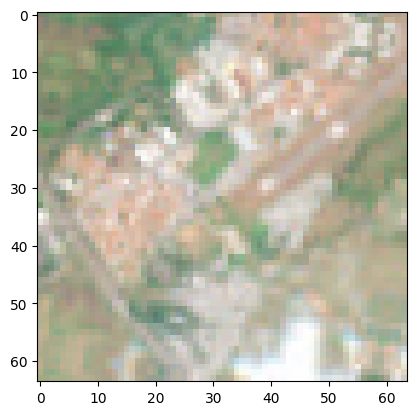

In [22]:
# Data augmentation - generate rotated images of urban tiles, to expand urban images x4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show

data_gen = ImageDataGenerator(rotation_range=180, fill_mode='reflect')

data_generator = data_gen.flow(
    urban_images,
    batch_size=50)
data_list = []
aug_urban_labels = []
batch_index = 0

while batch_index <= (urban_images.shape[0] * 4 ): # want to expand our urban images 4x to allow for multiple rotations
    data = data_generator.next()
    data_list.append(data[0])
    aug_urban_labels.append(1)
    batch_index = batch_index + 1

# convert to numpy array
aug_urban_images = (np.array(data_list)).astype(int)
aug_urban_labels = np.array(aug_urban_labels)
aug_urban_images.shape # now we have 457 images

# Plot
random_index = np.random.choice(aug_urban_images.shape[0])
imshow(aug_urban_images[random_index]) # show one image

In [23]:
# figure out later - plot one example of transformed images

(457, 64, 64, 3)

In [24]:
# Draw out just the non-urban images
non_urban_labels_index = np.where(labels_flip == 0)
non_urban_labels = labels_flip[non_urban_labels_index]
non_urban_images = images[non_urban_labels_index]

# Generate a random selection of non-urban images - the same number as urban images.
NU_labels_subset = []
NU_images_subset = []

for i in range(0, aug_urban_images.shape[0]):
  random_index_for_subset = np.random.choice(non_urban_labels.shape[0])
  subset_label = non_urban_labels[random_index_for_subset]
  subset_image = non_urban_images[random_index_for_subset]
  NU_labels_subset.append(subset_label)
  NU_images_subset.append(subset_image)

# Convert to numpy arrays
non_urban_images = np.array(NU_images_subset)
non_urban_labels = np.array(NU_labels_subset)

In [27]:
non_urban_images.shape

(914, 64, 64, 3)

In [26]:
# Combine urban and non-urban images and labels - now we have equal numbers of urban and non-urban elements.
subset_images = np.concatenate((non_urban_images, aug_urban_images), axis = 0) # 914 images
subset_labels = np.concatenate((non_urban_labels, aug_urban_labels), axis = 0)

Text(0.5, 1.0, 'Category is: Not Urban')

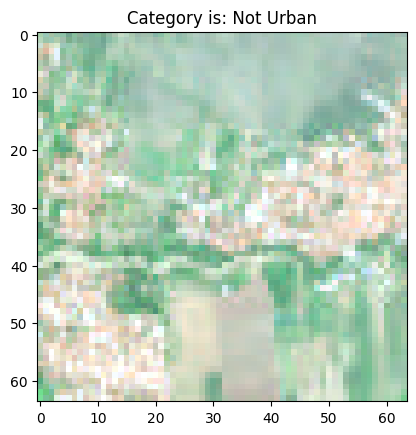

In [32]:
# Visualize Images
import matplotlib.pyplot as plt

random_index = np.random.choice(subset_labels.shape[0],1)
category_image = subset_images[random_index].reshape(64,64,3)
categories = ["Not Urban", "Urban"] # currently 0 = not urban and 1 = urban
plt.imshow(category_image)
plt.title(f"Category is: {categories[subset_labels[random_index][0]]}")

In [33]:
import sklearn

# split test and train data
from sklearn.model_selection import train_test_split 

# using the train test split function
(X_train, X_test, Y_train, Y_test) = train_test_split(subset_images, subset_labels,
                                                      stratify = subset_labels,
                                                        random_state=104, 
                                                        test_size=0.5, 
                                                        shuffle=True)

# Data Augmentation

In [ ]:
# pip install protobuf==3.20.0

In [20]:
# import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show

In [93]:
# function to plot augmented images

def plot(data_generator):
    """
    Plots 6 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(urban_images_aug)
    image_iterator = data_generator.flow(urban_images_aug)
    
    # plot images from iterator
    fig, rows = subplots(nrows=1, ncols=6, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    show()
    


In [ ]:
# # read in test image
# image_test = imread('./data/cirebon/urban/urban_103.jpg')

# # create dataset with one test image
# images_test = image_test.reshape((1, image_test.shape[0], image_test.shape[1], image_test.shape[2]))

# imshow(images_test[0])
# show()

In [ ]:
# apply transformations to test image
# data_generator = ImageDataGenerator(rotation_range=180, fill_mode='reflect')
# # data_generator = ImageDataGenerator(rotation_range=30, fill_mode='reflect')
# plot(data_generator)

In [ ]:
# # apply brightness
# data_generator = ImageDataGenerator(brightness_range=(0.7, 1.3))
# plot(data_generator)

# # let's not use this method

In [ ]:
# # apply zoom
# data_generator = ImageDataGenerator(zoom_range=[0.2, 2.5])
# plot(data_generator)

# # let's not use this method

In [26]:
urban_images_aug.shape

(114, 64, 64, 3)

In [24]:
urban_images.shape[0]

114

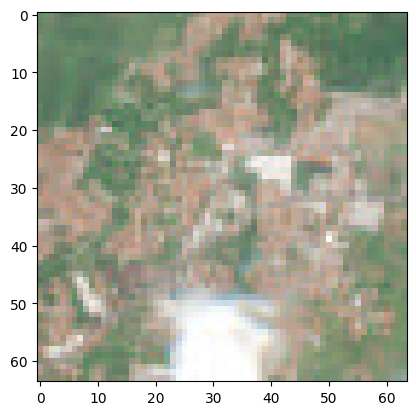

In [25]:
from matplotlib.pyplot import imread, imshow, subplots, show

# create dataset with all urban images (batch_size, height, width, channels)
urban_images_aug = urban_images.reshape((urban_images.shape[0], 64, 64, 3))

imshow(urban_images_aug[14]) # show one image
show()

In [27]:
# check dataset shape; should be (114, 64, 64, 3)
urban_images_aug.shape

(114, 64, 64, 3)

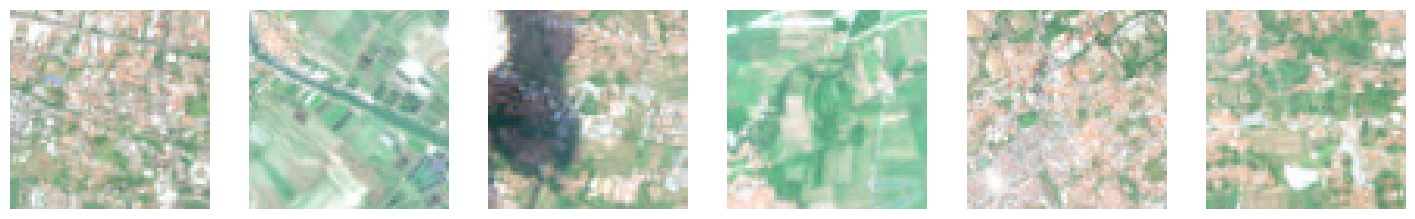

In [94]:
# apply transformations to urban images
data_generator = ImageDataGenerator(rotation_range=180, fill_mode='reflect')

plot(data_generator)

In [30]:
# generate augmented images
train_generator = data_generator.flow(urban_images_aug, batch_size=32)

In [47]:
data_generator

In [ ]:
# train model on augmented images
# model.fit_generator(train_generator, epochs=10, steps_per_epoch=len(x_train) / 32)

# Model 1 - Self-Made CNN

In [37]:
# Create handmade CNN
input_shape = (images.shape[1], images.shape[2], images.shape[3])
num_classes = 2

handmade_cnn = Sequential()
handmade_cnn.add(Conv2D(32, kernel_size=(3, 3), # Conv2D layer - apply 32 convolutions with a 3x3 kernel
                 activation='relu',
                 input_shape=input_shape))
handmade_cnn.add(MaxPooling2D(pool_size=(2, 2))) # Max Pooling 2D layer
handmade_cnn.add(Dropout(0.25)) # drop out
handmade_cnn.add(Flatten()) # flatten before putting into dense network
handmade_cnn.add(Dense(num_classes, activation='softmax')) # dense layer

# comment out summary for space
#handmade_cnn.summary()
#plot_model(handmade_cnn, show_shapes=True, show_layer_names=True)

In [38]:
# compile model
handmade_cnn.compile(
    loss='categorical_crossentropy',
    optimizer = "Adam",
              #optimizer=RMSprop(),
              metrics=['accuracy'])

# convert class vectors to binary class matrices
Y_train_cat = keras.utils.np_utils.to_categorical(Y_train, num_classes)
Y_test_cat = keras.utils.np_utils.to_categorical(Y_test, num_classes)

# train
history_handmade_cnn = handmade_cnn.fit(X_train, Y_train_cat, # training data
                    batch_size=2000,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, Y_test_cat)) # testing data

Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 77.6624 - accuracy: 0.5033 - val_loss: 678.0349 - val_accuracy: 0.4989
Epoch 2/100
1/1 [==============================] - 0s 131ms/step - loss: 682.3760 - accuracy: 0.5011 - val_loss: 608.6516 - val_accuracy: 0.4989
Epoch 3/100
1/1 [==============================] - 0s 115ms/step - loss: 612.9218 - accuracy: 0.5011 - val_loss: 327.1764 - val_accuracy: 0.4989
Epoch 4/100
1/1 [==============================] - 0s 109ms/step - loss: 330.9105 - accuracy: 0.5011 - val_loss: 7.0625 - val_accuracy: 0.5733
Epoch 5/100
1/1 [==============================] - 0s 117ms/step - loss: 17.3606 - accuracy: 0.5952 - val_loss: 228.6217 - val_accuracy: 0.5011
Epoch 6/100
1/1 [==============================] - 0s 113ms/step - loss: 229.4612 - accuracy: 0.4989 - val_loss: 268.7763 - val_accuracy: 0.5011
Epoch 7/100
1/1 [==============================] - 0s 110ms/step - loss: 270.3830 - accuracy: 0.4989 - val_loss: 201.5490 - val_accurac

In [39]:
handmade_cnn_score = handmade_cnn.evaluate(X_test, Y_test_cat, verbose=0)
accuracy_handmade_cnn = handmade_cnn_score[1]
print('Handmade Model accuracy:', round(accuracy_handmade_cnn, 3) * 100, "%")

Handmade Model accuracy: 76.4 %


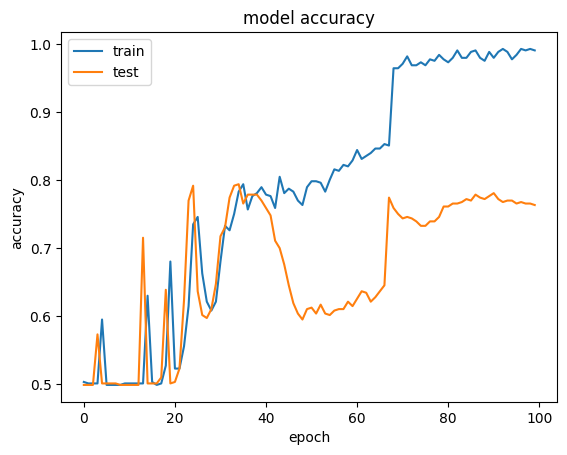

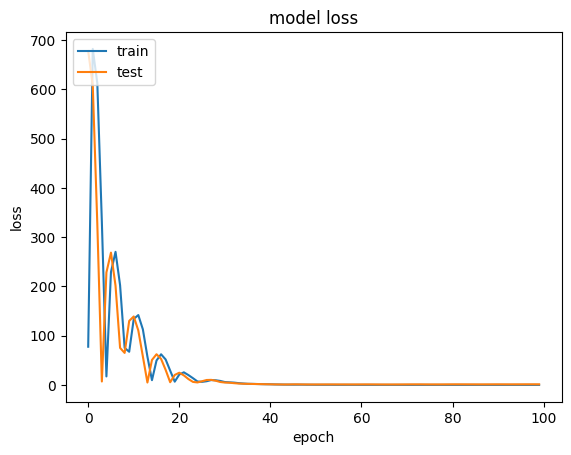

([<matplotlib.lines.Line2D at 0x7f7e000a5fd0>],
 Text(0.5, 1.0, 'model accuracy'),
 Text(24.000000000000007, 0.5, 'accuracy'),
 Text(0.5, 24.0, 'epoch'),
 None,
 Text(0.5, 1.0, 'model loss'),
 Text(24.000000000000007, 0.5, 'loss'),
 Text(0.5, 24.0, 'epoch'),
 None)

In [40]:
plot_accuracy_and_loss(history_handmade_cnn)

## Assess Accuracy

In [41]:
prediction_by_category(handmade_cnn, X_test)

15/15 [==============================] - 0s 6ms/step


<ipython-input-2-77b848b2e311>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,y_true,accurate_preds,label_count,class_acc,overall_acc
0,Not_Urban,164,228,0.719298,0.763676
1,Urban,185,229,0.807860,0.763676


15/15 [==============================] - 0s 3ms/step


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f7df00c8eb0>,
 Text(0.5, 1.0, 'Confusion Matrix, Handmade Model'))

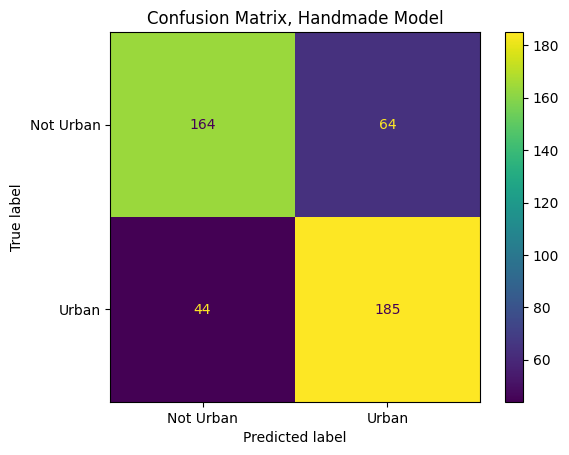

In [42]:
plot_cm(handmade_cnn, X_test, "Confusion Matrix, Handmade Model")

15/15 [==============================] - 0s 3ms/step


([<matplotlib.lines.Line2D at 0x7f7d58b84280>],
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 0, 'False Positive Rate or (1 - Specifity)'),
 Text(0, 0.5, 'True Positive Rate or (Sensitivity)'),
 Text(0.5, 1.0, 'Receiver Operating Characteristic'),
 <matplotlib.legend.Legend at 0x7f7d58bee8b0>)

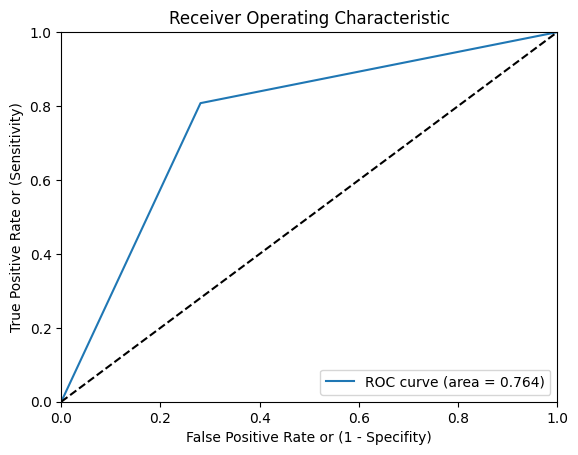

In [70]:
plot_roc_curve(handmade_cnn, X_test)

15/15 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Examples of False Positive Classifications - Predicted as Urban, but are officially not urban')

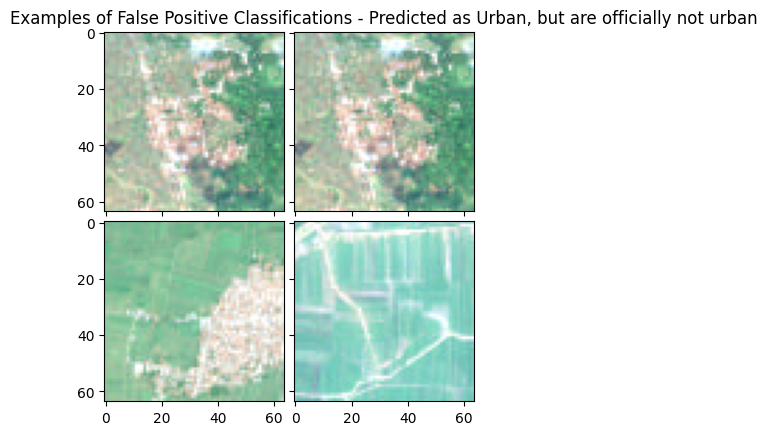

In [49]:
plot_false_positives(handmade_cnn, X_test)

# VGG-16

In [59]:
# load vgg model
from keras.applications.vgg16 import VGG16

# load the model
vgg16 = VGG16(weights='imagenet', include_top = False, input_shape=input_shape) # set VGG to trainable, set VGG to take images shaped as 64*64*3
#vgg16.summary()

# preprocess data for VGG16
from keras.applications.vgg16 import preprocess_input

X_train_vgg = preprocess_input(X_train) # normalize training data
X_test_vgg = preprocess_input(X_test) # normalize test data

58889256/58889256 [==============================] - 0s 0us/step


In [60]:
# Add last layers for our images
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
drop_out_layer = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

# set model architecture
vgg16_model = models.Sequential([
    vgg16,
    flatten_layer,
    dense_layer_1,
    drop_out_layer,
    dense_layer_2,
    prediction_layer
])

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# commenting out so it doesn't run accidentally - takes forever to run
history_vgg16 = vgg16_model.fit(X_train_vgg,
            Y_train_cat,
            epochs=50,
            validation_split=0.2,
            batch_size=32,
            callbacks=[es])

Epoch 1/50
12/12 [==============================] - 14s 281ms/step - loss: 36.5180 - accuracy: 0.4575 - val_loss: 0.6986 - val_accuracy: 0.4783
Epoch 2/50
12/12 [==============================] - 1s 59ms/step - loss: 0.7498 - accuracy: 0.4438 - val_loss: 0.6985 - val_accuracy: 0.4674
Epoch 3/50
12/12 [==============================] - 1s 59ms/step - loss: 0.6990 - accuracy: 0.4986 - val_loss: 0.6951 - val_accuracy: 0.3913
Epoch 4/50
12/12 [==============================] - 1s 62ms/step - loss: 0.7039 - accuracy: 0.4904 - val_loss: 0.6977 - val_accuracy: 0.5109
Epoch 5/50
12/12 [==============================] - 1s 59ms/step - loss: 0.7224 - accuracy: 0.5014 - val_loss: 0.7049 - val_accuracy: 0.5109
Epoch 6/50
12/12 [==============================] - 1s 57ms/step - loss: 0.7033 - accuracy: 0.4767 - val_loss: 0.6995 - val_accuracy: 0.5109
Epoch 7/50
12/12 [==============================] - 1s 63ms/step - loss: 0.7009 - accuracy: 0.4959 - val_loss: 0.6944 - val_accuracy: 0.5326
Epoch 8/50

In [62]:
vgg16_model_score = vgg16_model.evaluate(X_test_vgg, Y_test_cat, verbose=0)
accuracy_vgg16_model = vgg16_model_score[1]
print('VGG-16 Test accuracy:', round(accuracy_vgg16_model, 3) * 100, "%") 

VGG-16 Test accuracy: 67.4 %


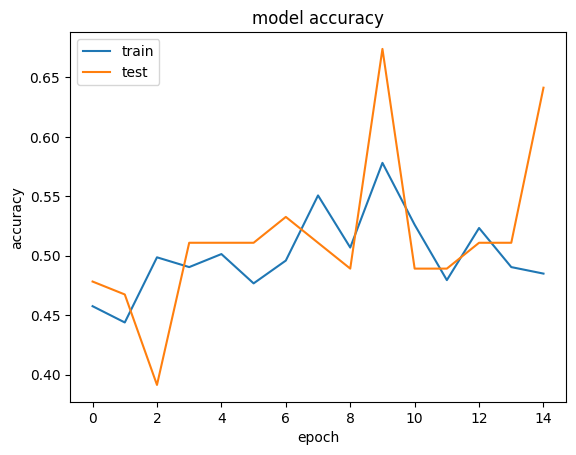

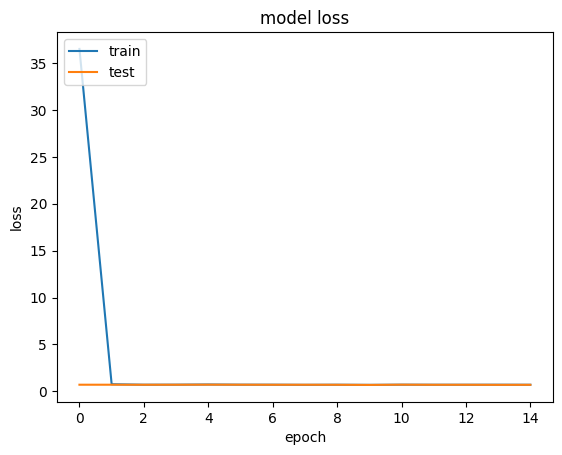

([<matplotlib.lines.Line2D at 0x7f7d57fa24f0>],
 Text(0.5, 1.0, 'model accuracy'),
 Text(24.000000000000007, 0.5, 'accuracy'),
 Text(0.5, 24.0, 'epoch'),
 None,
 Text(0.5, 1.0, 'model loss'),
 Text(24.000000000000007, 0.5, 'loss'),
 Text(0.5, 24.0, 'epoch'),
 None)

In [63]:
plot_accuracy_and_loss(history_vgg16)

In [64]:
prediction_by_category(vgg16_model, X_test_vgg)

15/15 [==============================] - 0s 13ms/step


<ipython-input-2-77b848b2e311>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,y_true,accurate_preds,label_count,class_acc,overall_acc
0,Not_Urban,212,228,0.929825,0.673961
1,Urban,96,229,0.419214,0.673961


15/15 [==============================] - 0s 13ms/step


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f7d58682640>,
 Text(0.5, 1.0, 'Confusion Matrix: VGG16'))

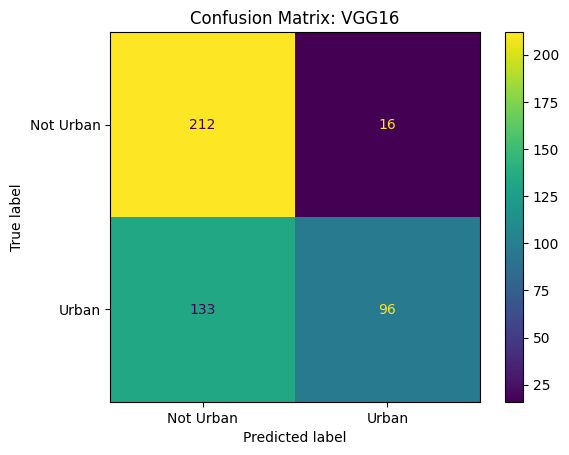

In [65]:
plot_cm(vgg16_model, X_test_vgg, "Confusion Matrix: VGG16")

15/15 [==============================] - 0s 13ms/step


([<matplotlib.lines.Line2D at 0x7f7d585b90a0>],
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 0, 'False Positive Rate or (1 - Specifity)'),
 Text(0, 0.5, 'True Positive Rate or (Sensitivity)'),
 Text(0.5, 1.0, 'Receiver Operating Characteristic'),
 <matplotlib.legend.Legend at 0x7f7d585990a0>)

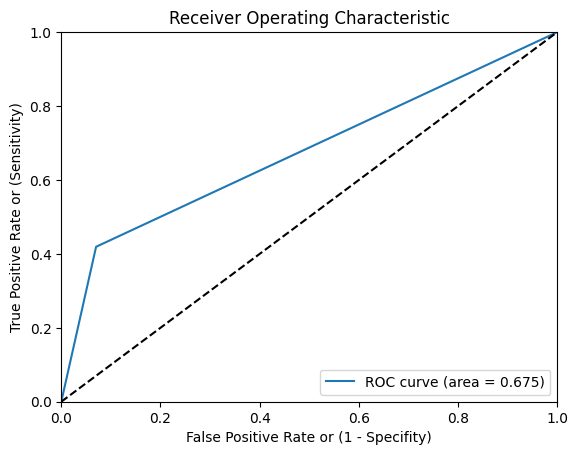

In [66]:
plot_roc_curve(vgg16_model, X_test_vgg)

15/15 [==============================] - 0s 13ms/step


Text(0.5, 1.0, 'Examples of False Positive Classifications - Predicted as Urban, but are officially not urban')

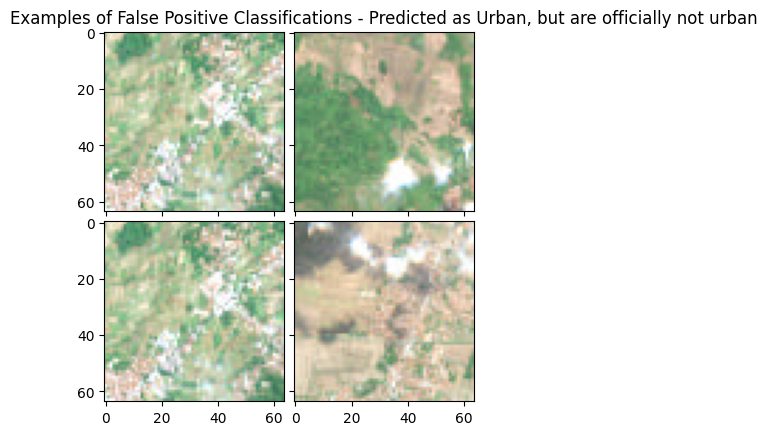

In [67]:
plot_false_positives(vgg16_model, X_test_vgg) # does not work because predicted no positives

# EfficientNet V2
https://arxiv.org/abs/2104.00298

In [71]:
# load model
from keras.applications.efficientnet_v2 import EfficientNetV2S

# load the model
eff_net = EfficientNetV2S(weights='imagenet', include_top = False, input_shape=input_shape) # set to trainable, set to take images shaped as 64*64*3
#eff_net.summary()

# preprocess data for EfficientNet
from keras.applications.efficientnet_v2 import preprocess_input

X_train_EN = preprocess_input(X_train) # normalize training data
X_test_EN = preprocess_input(X_test) # normalize test data

82420632/82420632 [==============================] - 1s 0us/step


In [72]:
# Add last layers for our images

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
drop_out_layer = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

# set model architecture
efficient_net_model = models.Sequential([
    eff_net,
    flatten_layer,
    dense_layer_1,
    drop_out_layer,
    dense_layer_2,
    prediction_layer
])

In [73]:
# Compile
efficient_net_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# Train
history_efficient_net = efficient_net_model.fit(X_train_EN,
            Y_train_cat,
            epochs=50,
            validation_split=0.2,
            batch_size=32,
            callbacks=[es])

Epoch 1/50
12/12 [==============================] - 100s 597ms/step - loss: 0.5695 - accuracy: 0.7068 - val_loss: 0.4010 - val_accuracy: 0.8370
Epoch 2/50
12/12 [==============================] - 1s 123ms/step - loss: 0.2847 - accuracy: 0.8849 - val_loss: 0.4119 - val_accuracy: 0.9130
Epoch 3/50
12/12 [==============================] - 1s 102ms/step - loss: 0.1866 - accuracy: 0.9288 - val_loss: 0.4291 - val_accuracy: 0.8913
Epoch 4/50
12/12 [==============================] - 1s 104ms/step - loss: 0.1553 - accuracy: 0.9397 - val_loss: 0.5943 - val_accuracy: 0.9130
Epoch 5/50
12/12 [==============================] - 2s 168ms/step - loss: 0.1172 - accuracy: 0.9616 - val_loss: 0.2807 - val_accuracy: 0.9348
Epoch 6/50
12/12 [==============================] - 2s 169ms/step - loss: 0.0759 - accuracy: 0.9671 - val_loss: 0.2509 - val_accuracy: 0.9674
Epoch 7/50
12/12 [==============================] - 1s 103ms/step - loss: 0.0518 - accuracy: 0.9836 - val_loss: 0.2885 - val_accuracy: 0.9674
Epoc

In [74]:
efficient_net_model_score = efficient_net_model.evaluate(X_test_EN, Y_test_cat, verbose=0)
accuracy_eff_net = efficient_net_model_score[1]
print('EfficientNetV2 Test accuracy:', round(accuracy_eff_net, 3) * 100, "%") 

EfficientNetV2 Test accuracy: 89.3 %


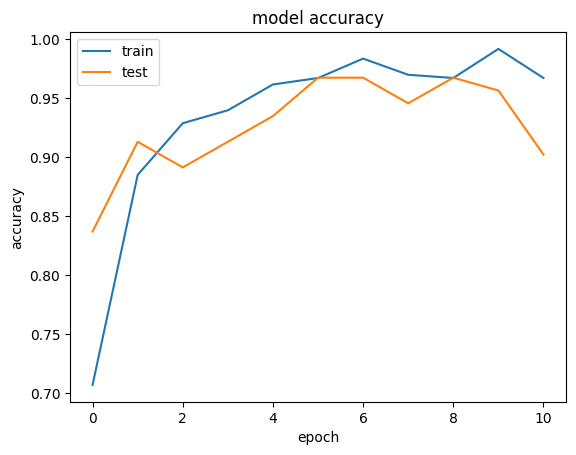

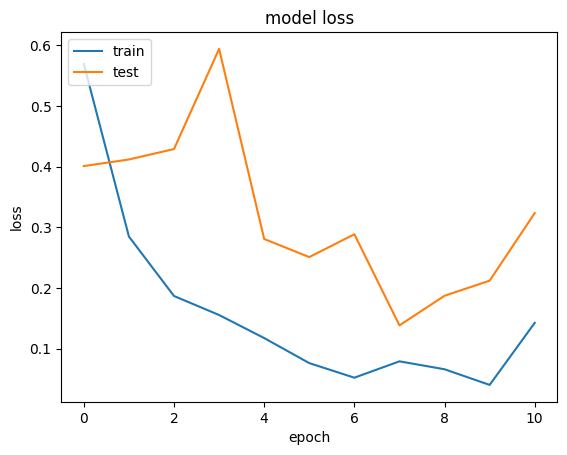

([<matplotlib.lines.Line2D at 0x7f7d41fe79d0>],
 Text(0.5, 1.0, 'model accuracy'),
 Text(24.000000000000007, 0.5, 'accuracy'),
 Text(0.5, 24.0, 'epoch'),
 None,
 Text(0.5, 1.0, 'model loss'),
 Text(24.000000000000007, 0.5, 'loss'),
 Text(0.5, 24.0, 'epoch'),
 None)

In [75]:
plot_accuracy_and_loss(history_efficient_net)

In [76]:
prediction_by_category(efficient_net_model, X_test_EN)

15/15 [==============================] - 4s 30ms/step


<ipython-input-2-77b848b2e311>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,y_true,accurate_preds,label_count,class_acc,overall_acc
0,Not_Urban,186,228,0.815789,0.892779
1,Urban,222,229,0.969432,0.892779


15/15 [==============================] - 0s 19ms/step


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f7d4226b0d0>,
 Text(0.5, 1.0, 'Confusion Matrix, EfficicentNetV2'))

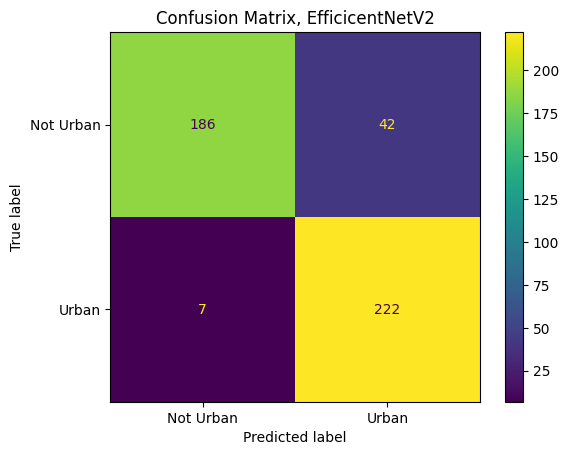

In [77]:
plot_cm(efficient_net_model, X_test_EN, "Confusion Matrix, EfficicentNetV2")

15/15 [==============================] - 0s 19ms/step


([<matplotlib.lines.Line2D at 0x7f7d420fcdf0>],
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 0, 'False Positive Rate or (1 - Specifity)'),
 Text(0, 0.5, 'True Positive Rate or (Sensitivity)'),
 Text(0.5, 1.0, 'Receiver Operating Characteristic'),
 <matplotlib.legend.Legend at 0x7f7d42164a30>)

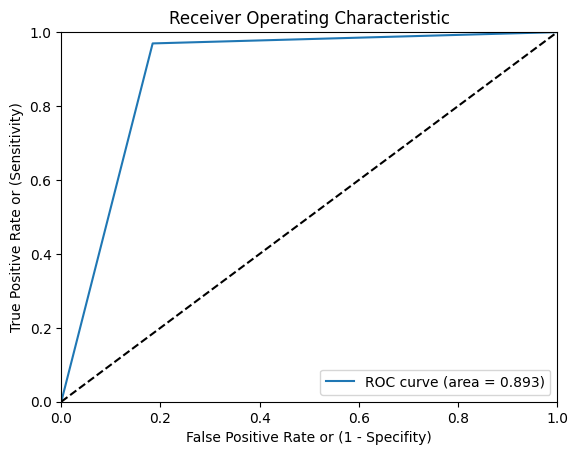

In [78]:
plot_roc_curve(efficient_net_model, X_test_EN)

15/15 [==============================] - 0s 27ms/step


Text(0.5, 1.0, 'Examples of False Positive Classifications - Predicted as Urban, but are officially not urban')

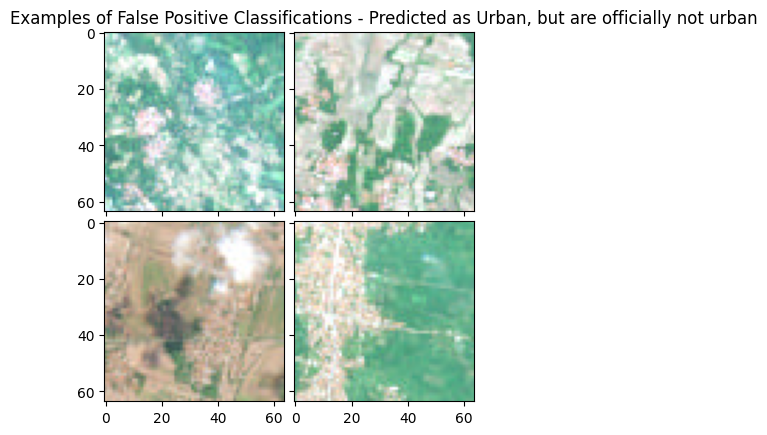

In [81]:
plot_false_positives(efficient_net_model, X_test_EN)